In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.integrate import solve_ivp, odeint

# Modelamiento NanoCapsulas

Basado en el modelo de Ferrari [1] de la particula reactiva, como se observa en la siguiente figura

<img src="./imagenes/Esquema_modelo_capsula.png" alt="Escquema modelo nanocapsula de silice" style="width:650px;"/>

 - En la región donde estaria el cascaron de silice solo habria difusión
 - En la region nuclear de la capsula habria tanto reacción con el agente activo como reacción
 
Con base en esto se define una ecuación de transporte para la concentracion de oxígeno de tipo 

$$\frac{\partial C_{O_2}}{\partial t }= D(r)\nabla^2 C_{O_2} + (1-H(r-R_{in}))R_{O_2}$$

Para poder modelar correctamente las nanocapsulas se debe calcular la cantidad de aceite encapsulado en una sola capsula , esto con el fin de calcular el radio del nucleo reactivo y el grosor del cascaron de silice.

Segun los TGA realizados a las nancapsulas de silice el porcentaje en peso de aceite de linaza encapsulado dentro del cascaron de silice corresponde a 35.46% mientras que el cascarón corresponde a un 46.33%. 

<img src="./imagenes/TGA_Nanocapsulas.png " alt="TGA Nanocapsulas de silice con aceite" style="width:650px;"/>

Dado que se asumira que las nanocpasulas solo estan compuestas de estos dos materiales se va a normalizar con respecto al 81.76% que representan estos dos cantidades, por lo cual el aceite representaria un 43.37% del peso total mientras que el cascaron de silice representaria el 56.63%wt restante. 

Ahora considerando que el diametro de una nanocapsula de silice es aproximadamente 121nm se puede calcular un volumen de $9.44x10^{-22} m^3$ (asumiendo geometria perfectamente esferica). Sabiendo esto y dado que deseamos encontrar la cantidad de silice y aceite en una nanocapsula, para esto se midio la densidad de las nanocapsulas con ayuda de un pignometro encontrando que esta tiene una densidad de 0.3724g/ml, de ahi que se tiene una nanoncapsula tiene un peso $W=\rho *V=3.52x10^{-19} kg$. Teniendo el peso de una sola nanocapsula, se calcula el volumen de aceite de linaza que contiene una capsula. Se sabe que el peso del aceite de linaza en la nanocapsula sera $43.37\%*W=1.52x10^{-19} kg$, y asi mismo se conoce que dicho aceite tiene una densidad de 931 kg/m3 de ahi que el volumen de aceite en la nancapsula sera de $3.0655x10^{-22}m^3$. Finalmente con dicho volumen podemos calcular el radio de la esfera aceite que se encuentra en el centro de la nanocapsula, el cual sera de $r_{int}=33.94nm$, de ahi que se puede calcular el grosor del cascaron de silice restandole al radio total de la nanocapsula, el radio interno del nuecloe de aceite con lo cual se obtiene un grosor de silice de 26.91nm.

Teniendo estos valores, podemos llevar a cabo una simulación de lo que seria el consumo de oxigeno por parte de la nanocapsula y comparar este desempeño con las mediciones experimentales de captura oxígeno en el espacio de cabeza. El dominio computacional de la simulacion estara dividido en dos partes, una seccion correspondiente al cascaron de silice donde solo habra difusion de oxigeno (esta seccion estara dada para $R_{int}<r<R_{ext}$) y la region del nucleo de aceite donde habran tanto difusion como reaccion de oxigeno con el aceite ($r>R_{int}$).

Ahora con el fin de simplificar el problema, se llevará a cabo una simulacion 1D puesto que el sistema posee simetria esferica y la concentracion solo varia de manera radial. De ahi que la ecuacion de transporte a resolver se puede escribir como 

> <div style="text-align:center">$\frac{\partial C_{O_2}}{\partial t }= D(r)\frac{1}{r^2}\frac{\partial}{\partial r} \left(r^2 \frac{\partial C_{O_2}}{\partial r}\right) + (1-H(r-R_{int}))R_{O_2}$</div>

En donde la difusividad en funcion del radio $D(r)$ estara dada por 

  $$ D(r)=   \left\{
\begin{array}{ll}
      D_{Si} & R_{int}<r<R_{ext} \\
      D_{Ac} & r<R_{int} \\
\end{array} 
\right.  $$

Asi mismo la funcion escalón $H(r-R_{int})$ esta definida como 

  $$ H(r-R_{int})=   \left\{
\begin{array}{ll}
      1 & R_{int}<r \\
      0 & r<R_{int} \\
\end{array} 
\right.  $$

y finalmente el término reactivo de la ecuación esta descrito segun la siguinte cinetica de oxidacion

> <div style="text-align:center">2ROOH $\xrightarrow{k_1}$ ROO<sup>$\cdot$</sup> + R<sup>$\cdot$</sup> </div>
> <div style="text-align:center">R<sup>$\cdot$</sup>+ O<sub>2</sub> $\xrightarrow{k_2}$ ROO<sup>$\cdot$</sup> </div>
> <div style="text-align:center">ROO<sup>$\cdot$</sup>+ RH $\xrightarrow{k_3}$ ROOH+R<sup>$\cdot$</sup> </div>
> <div style="text-align:center">2R<sup>$\cdot$</sup> $\xrightarrow{k_4}$ Producto inactivo </div>
> <div style="text-align:center">R<sup>$\cdot$</sup> + ROO<sup>$\cdot$</sup> $\xrightarrow{k_5}$ Producto inactivo </div>   
> <div style="text-align:center">2ROO<sup>$\cdot$</sup> $\xrightarrow{k_6}$ Producto inactivo </div>

Por lo cual $R_{O_2}=-k_2C_{O_2}C_{R^\cdot}$. Ya habiendo definido cada termino de la ecuación de transporte se prodece a realizar la discretización del dominio sobre la cual se va a resolver la ecuación. Para esto la variable continua pasara a ser discreta como $r\xrightarrow{}r_i, 0<i<n+1$ y $t\xrightarrow{}t^j, 0<j<m$. Por otro lado se debe especificar que esquemas de discretizacion se usaran para poder solucionar la ecuacion diferencial, en este caso esta se solucionara por del metodo de lineas (MOL) en el cual se expresa explicitamente las derivdas y funciones que dependen del espacion con el fin de obtener una ecuacion diferencial ordinaria con respecto al tiempo, la cual se va a solucionar a su vez por el metodo de BDF. Ahora bien, para el esquema de discretizacion que se va a utilizar para el termino difusivo de la reaccion se aplicará un esquema central de segundo orden 

$$D(r)\frac{1}{r^2}\frac{\partial}{\partial r} \left(r^2 \frac{\partial C_{O_2}}{\partial r}\right)= D_i\frac{1}{\Delta r^2}\left(\left(1+\frac{\Delta r}{r_i}\right)C_{i+1} -2C_i+\left(1-\frac{\Delta r}{r_i}\right)C_{i-1}\right)$$

Asi mismo la discretizacion del termino reactivo y la funcion escalon sera

$$R_{O_2}=-(1-H(r_i-R_{int}))k_2C_{O_2 ,i}C_{R^\cdot, i}$$

Con esto ultimo, la ecuacion parcial diferencial se puede resscribir como una ecuacion diferencial ordnaria con respecto a las variables de concentracion y espacio discretizados

$$\frac{\partial C_{O_2}}{\partial t }= D_i\frac{1}{\Delta r^2}\left(\left(1+\frac{\Delta r}{r_i}\right)C_{i+1} -2C_i+\left(1-\frac{\Delta r}{r_i}\right)C_{i-1}\right) -(1-H(r_i-R_{int}))k_2C_{O_2 ,i}C_{R^\cdot, i}$$

Finalmente se establecen las condiciones de frontera e iniciales del problema. Las condiciones de frontera seran que la capsula esta expuesta a una concentracion constasnte de oxígeno fuera de la capsula (lo cual asume que la capsula esta permanente expuesta al aire), mientras que para la condicion en elc entro de la esfera sera que no hay flux o flujo de oxigeno dado que este punto representa un eje de simetria del sistema considerado.

> 1. $C_{O_2}(t,r=R_{ext})=C_o$;
> 2. $\frac{\partial C_{O_2}}{\partial r}(t,r=0)=0$

Por otro lado la condicion inicial del sistema sera que inicialmente no habra oxigeno en ninguna parte de la capsula, mientras que la concentracion inicial de las demas especies estara dada por la concentracion que tienen en el aceite de linaza. 

Con el fin de tener en cuenta las condiciones de frontera en la ecuacion diferencial discretizada se aproxima la condicion de frontera 2 segun un esquema central alrededor $C_{O_2,0}$ y se establece una variable fantasma $C_{O_2,-1}$;

$$\frac{\partial C_{O_2}}{\partial r}(t,r=0)=\frac{ C_{O_2,1}-C_{O_2,-1}}{2 \Delta r}=0$$
$$C_{O_2,-1}=C_{O_2,1}$$

Con lo cual se tiene que la ecuacion diferencial que resolver para la variable $C_{O_2,0}$ sera

$$\frac{\partial C_{O_2,0}}{\partial t }= D_0\frac{2}{\Delta r^2}\left(C_{1} -C_0\right) -(1-H_0)k_2C_{O_2 ,0}C_{R^\cdot, 0}$$

Antes de resolver la ecuacion diferencial planteada previamente se debe determinar el mecanismo de transporte del oxígeno a travez de la pared porosa de silice que recubre el aceite de linaza en la nanocapsula. Para esto se calculó el numero adimensional de Kndusen como 

$$K_n=\frac{\lambda}{\bar{\sigma}}$$

Donde $\bar{\sigma}$ representa el diametro de poro promedio mientras que $\lambda$ representa el camino libre medio del oxigeno el cual se calcula como 

$$\lambda=\frac{1}{\sqrt{2}\pi d_m^2c N_A}$$

A continuacion se muestra el calculo del numero de Knudsen utilizando como el diametro promedio de poro el valor obtenido por R.Gomez en sus tesis de maestría.

In [137]:
#Condiciones calculo camino libre medio
P=74660.32 #Pa
T=293 #K

#Constantes 
R=8.314 #J/mol K
Na=6.022e23 
#Propiedades oxigeno
d_m=346e-12 #m diametro kinetico O_2
c=0.21*P/(R*T) #mol/m3 concentracion de oxigeno en el aire

#Camino libre medio 
lamnda=1/(np.sqrt(2)*np.pi*d_m**2*c*Na) #m

#Diametro de poro
sigma=36.96e-10 #m 

#numero de Knudsen
K_n=lamnda/sigma
print(K_n)

131.24377600230085


Dado que se obtuvo un $K_n>10$, se puede decir que el mecanismo de tranporte que govierna el movimiento del oxigeno a lo largo de la membrana de sílice es el flujo de Knudsen, en el cual se considera que las moleculas de gas chocan con mayor frecuencia con la membrana solidad que con otra moleculas de gas. Por esta razon se debe calcular la difusividad de kndusen para este caso, la cual se obtiene utilizando la siguiente formula 

$$D_{i,k}=-K_o\bar{v}_i$$

Donde $K_o$ da razon de la geometria de la estructura porosa de la membrana y $\bar{v}_i$ da razon de la velocidad promedio de las moleculas de oxígeno. Estas ultimas dos cantidade se calculan utilizando las siguientes ecuaciones

$$\bar{v}=\sqrt{\frac{8RT}{\pi M}}$$
$$K_o=\frac{2}{3}r_p\frac{\varepsilon}{\tau^2}$$

$\varepsilon$ representa la porosidad de la silice mientras que $\tau$ representa la tortuosidad de la misma. Para calcular la porosidad se tomo el volumen de vacio obtenido experimental por R.Gomez a travez de sortometria y se dividio esta entre el volumen total de la capsula el cual se calculó dividiendo el volumen de la capsula y su peso estimado.  Una vez se tiene calculado la porosidad se estima la tortuosidad utilizando la relación de Bruggerman la cual establece que 

$$\tau^2 =\varepsilon^{1-1.5}$$

Aplicando las relaciones anteriores se obtiene el sigueinte resultado para la difusividad de knudsen

In [1]:
#Propiedades oxigeno
M=32e-3 #Kg/mol

#Propiedades Membrana 
vol_capsula=(4/3)*np.pi*(121.71e-7/2)**3 #cm3
peso_capsula=3.52e-16#g
vol_total=vol_capsula/peso_capsula
vol_poro=0.7183 #cm3/g

E=vol_poro/vol_total #Porosidad 
t_2=E**(1-1.5) #Tortuosidad 

#Calculo difusividad
def dif_knudsen(T=298):
    Ko=1/3 *d_m*E/t_2;
    v=np.sqrt(8*R*T/(np.pi*M))
    D_k=Ko*v
    return D_k

print("Dk=",dif_knudsen(),"m2/s")
print("Porosidad=",E*100,"%")

NameError: name 'np' is not defined

Ya conociendo la difusividad del oxigeno en silice se puede proceder a realizar la simulacion de la oxidacion de la nanocapsula.Para realizar esta en primer lugar se simulara la capsula a una temperatura de 80°C en una atmosfera de vacio en aire de 0.6MPa durante 4h para simular la oxidacion durante el secado de las capsulas.Tras esto se modelara 350h de oxidacion en las cuales se habilitara el consumo de oxigeno por parte de la capsula a una temperatura de 20°C.

## Simulación 

In [139]:
#Dimensiones Capsula
r_ext=6.09E-8 #[m]
r_in=3.3940E-08 #[m]

#Vector de radio discretizado
n=500
r=np.linspace(0,r_ext,n)
delta_r=r[1];

#Funcion Escalon 
H=(r_in<r).astype(int);
frontera=np.ravel(np.asarray(H==1).nonzero())[0]

#Difusividad y solubilidad de oxigeno en aceite
def Difusividad(H,T=298):
    Dac=0.4e-9 #m2/s
    D_k=dif_knudsen(T) #m2/s
    return D_k*H+Dac*(1-H)

def Solubilidad(H,T=298):
    R=8.314;
    Sac=6.858e6*np.exp(-1.478e4/(R*T)); #Pa m3/mol
    return H/(R*T)+(1-H)/Sac

def cons_cinetica(T=298):
    R=8.314;
    return np.asarray([52691244*np.exp(-101.5e3/(R*T)),6581,572.68*np.exp(-31e3/(R*T)),2.2914e+08,10362358.9,96814085.92*np.exp(-48.4e3/(R*T))])

def ODE_reaccion(t,C):
    C=np.reshape(C,[5,n]).transpose();
    dC=np.empty([n,5])
    
    dC[:,0]=-2*k[0]*C[:,0]**2+k[2]*C[:,1]*C[:,3];
    dC[:,1]=k[0]*C[:,0]**2+k[1]*C[:,2]*C[:,4]*S-k[2]*C[:,1]*C[:,3]-k[4]*C[:,2]*C[:,1]-2*k[5]*C[:,1]**2;
    dC[:,2]=k[0]*C[:,0]**2-k[1]*C[:,2]*C[:,4]*S+k[2]*C[:,1]*C[:,3]-2*k[3]*C[:,2]**2-k[4]*C[:,2]*C[:,1];
    dC[:,3]=-k[2]*C[:,1]*C[:,3];
    
    dC[0,-1]=(D[0]/delta_r**2)*(2*C[1,-1]-2*C[0,-1])-(1-H[0])*k[1]*C[0,-1]*C[0,2];
    dC[1:n-1,-1]=(D[1:n-1]/delta_r**2)*((1+delta_r/r[1:n-1])*C[2:n,-1]-2*C[1:n-1,-1]+(1-delta_r/r[1:n-1])*C[:n-2,-1])-(1-H[1:-1])*k[1]*C[1:-1,-1]*C[1:-1,2];
    dC[-1,-1]=D[-1]*(1/(delta_r**2))*((1-delta_r/r[-1])*C[-2,-1]-2*C[-1,-1]+(1+delta_r/r[-1])*Co)-(1-H[-1])*k[1]*C[-1,-1]*C[-1,2];
    
    j=frontera;
    dC[j-1,-1]=(D[j]/(3*(D[j-1]+(D[j]))))*(4*dC[j,-1]-dC[j+1,-1])+(D[j-1]/(3*(D[j-1]+(D[j]))))*(4*dC[j-2,-1]-dC[j-3,-1]) 
    dC[j-1,:-1]=0.5*(dC[j-1,:-1]+dC[j,:-1])   
    
    dC=np.reshape(dC.T,5*n);
    return dC   
def ODE_consumo(t,C):
    C_ext=C[-1]
    C=np.reshape(C[:-1],[5,n]).transpose();
    dC=np.empty([n,5])
    
    dC[:,0]=-2*k[0]*C[:,0]**2+k[2]*C[:,1]*C[:,3];
    dC[:,1]=k[0]*C[:,0]**2+k[1]*C[:,2]*C[:,4]*S-k[2]*C[:,1]*C[:,3]-k[4]*C[:,2]*C[:,1]-2*k[5]*C[:,1]**2;
    dC[:,2]=k[0]*C[:,0]**2-k[1]*C[:,2]*C[:,4]*S+k[2]*C[:,1]*C[:,3]-2*k[3]*C[:,2]**2-k[4]*C[:,2]*C[:,1];
    dC[:,3]=-k[2]*C[:,1]*C[:,3];
    
    dC[0,-1]=(D[0]/delta_r**2)*(2*C[1,-1]-2*C[0,-1])-(1-H[0])*k[1]*C[0,-1]*C[0,2];
    dC[1:-1,-1]=(D[1:-1]/delta_r**2)*((1+delta_r/r[1:-1])*C[2:,-1]-2*C[1:-1,-1]+(1-delta_r/r[1:-1])*C[:-2,-1])-(1-H[1:-1])*k[1]*C[1:-1,-1]*C[1:-1,2];
    dC[-1,-1]=D[-1]*(1/(delta_r**2))*((1-delta_r/r[-1])*C[-2,-1]-2*C[-1,-1]+(1+delta_r/r[-1])*C_ext)-(1-H[-1])*k[1]*C[-1,-1]*C[-1,2];
    
    j=frontera;
    dC[j-1,-1]=(D[j]/(3*(D[j-1]+(D[j]))))*(4*dC[j,-1]-dC[j+1,-1])+(D[j-1]/(3*(D[j-1]+(D[j]))))*(4*dC[j-2,-1]-dC[j-3,-1]) 
    dC[j-1,:-1]=0.5*(dC[j-1,:-1]+dC[j,:-1])   

    dC=np.reshape(dC.T,5*n);
    
    V=(P_N2/(P-C_ext))*Vo
    dC_ext=D[-1]*(1/(2*delta_r))*(-3*C[-1,-1]+4*C[-2,-1]-C[-3,-1]) *(A/V);
    
    
    return np.append(dC,dC_ext)   


In [140]:
T=273+80;
Po=P-6e4;
#Funcion Difusividad
D=Difusividad(H,T)
S=Solubilidad(H,T)
k=cons_cinetica(T)

#Vector de inicializacion
C=np.ones([n,5])*np.asarray([19.1789709,0,0,1559.37052,0])
C[:,:4] = (C[:,:4].transpose() * (1-H)).transpose()
C=np.reshape(C.transpose(),5*n);
Co=Po*0.206 #[mol/m3];

t=np.linspace(0,3600*4,3600*4+1);
sol_reac=solve_ivp(ODE_reaccion,[t[0],t[-1]],C,method='BDF');

C:\Users\rozog\.conda\envs\spyder\lib\site-packages\scipy\integrate\_ivp\bdf.py:403: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


In [141]:
#Condicones de Reaccion
T=273+20;
Po=P;
P_N2=0.794*P#[Pa]

#Area Y volumen considerados
A=(4*np.pi*r_ext**2)*(1.2/peso_capsula)*0.021 #[m2]
#A=0.0112;
Vo=1.2e-4 #[m3]

#Funcion Difusividad
D=Difusividad(H,T)
S=Solubilidad(H,T)
k=cons_cinetica(T)

#Vector de inicializacion
C=sol_reac.y[:,-1]
Co=P*0.206 #[mol/m3];
C=np.append(C,Co)

t=np.linspace(0,3600*350,3600*4+1);
sol_consumo=solve_ivp(ODE_consumo,[t[0],t[-1]],C,method='BDF');

<IPython.core.display.Javascript object>


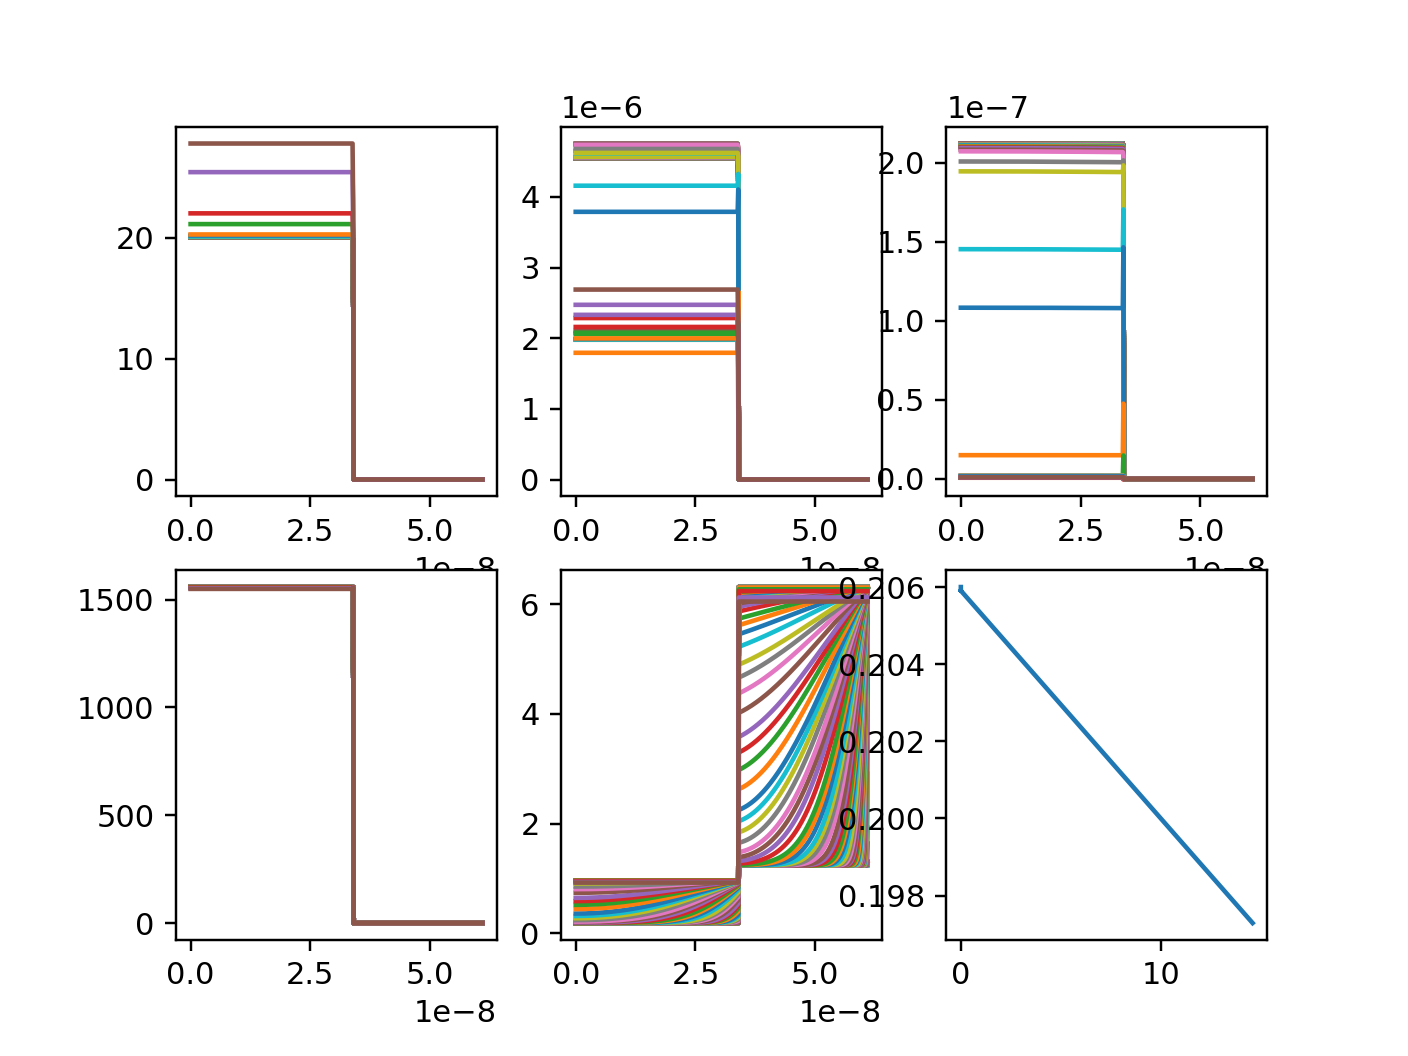

In [142]:
fig=plt.figure()
p=sol_reac.y[4*n:,:].T/S
ax0 = fig.add_subplot(231)
ax1 = fig.add_subplot(232)
ax2 = fig.add_subplot(233)
ax3 = fig.add_subplot(234)
ax4 = fig.add_subplot(235)
ax5 = fig.add_subplot(236)

ax0.plot(r[:],sol_consumo.y[0*n:1*n,:]);
ax1.plot(r[:],sol_consumo.y[1*n:2*n,:]);
ax2.plot(r[:],sol_consumo.y[2*n:3*n,:]);
ax3.plot(r[:],sol_consumo.y[3*n:4*n,:]);
ax4.plot(r[:],(sol_consumo.y[4*n:5*n,:].T*S).T);
ax5.plot(sol_consumo.t/(3600*24),sol_consumo.y[-1,:]/(P));
#ax5.set_ylim([0,0.21])

<IPython.core.display.Javascript object>


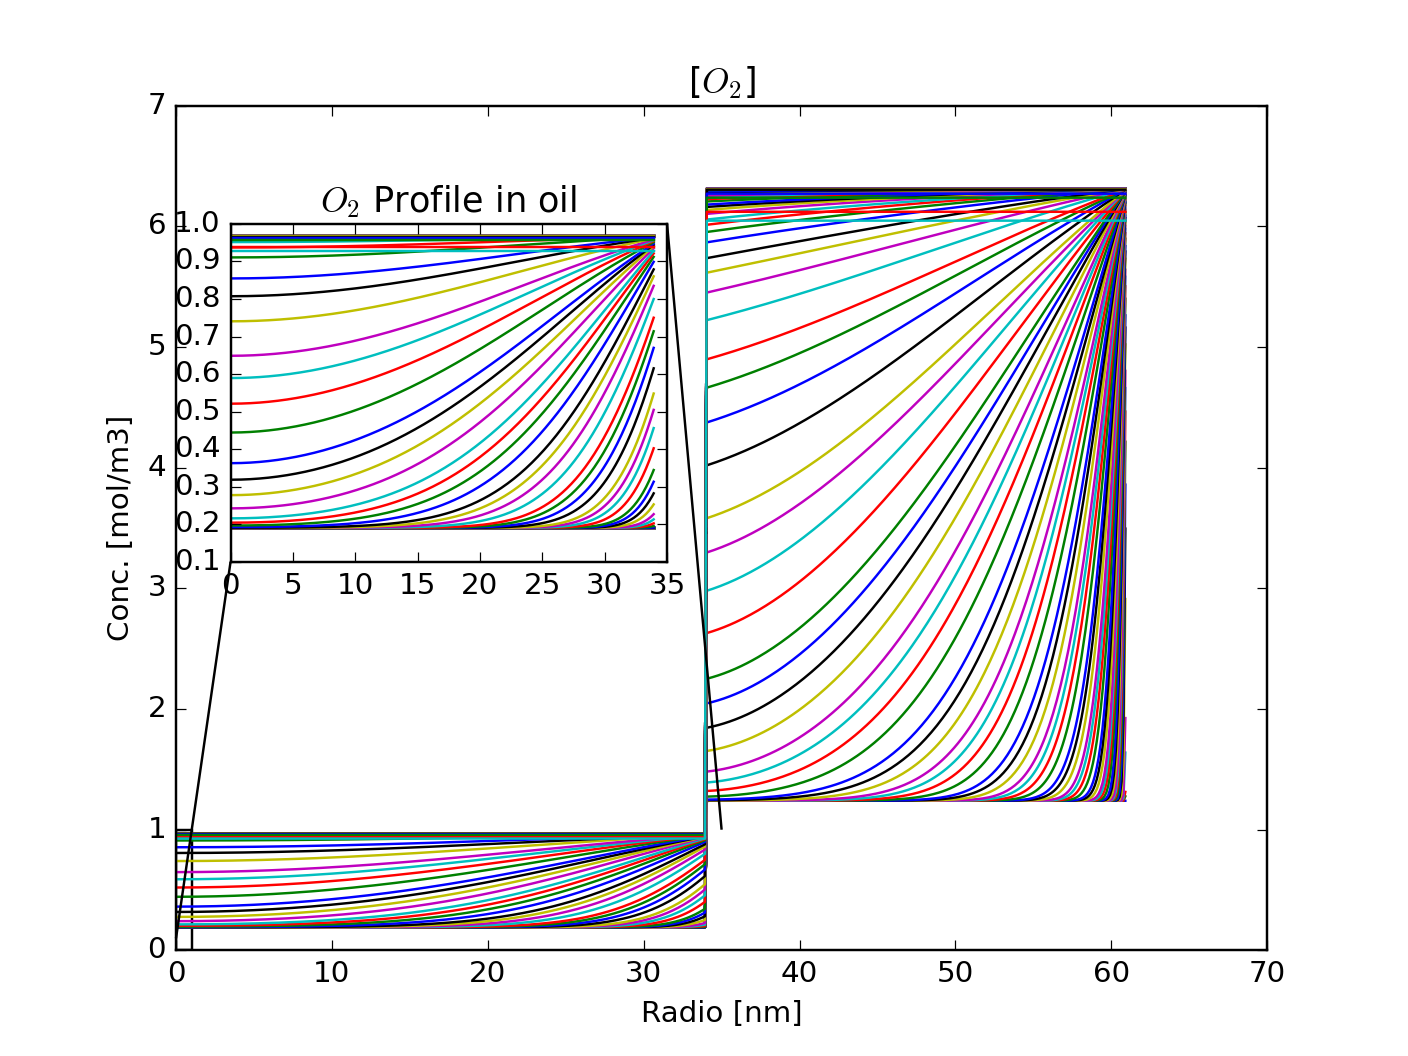

In [149]:
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

plt.style.use('classic')
fig=plt.figure(facecolor='w')
ax1= fig.add_subplot(111)
ax1.plot(r[:]*1e9,(sol_consumo.y[4*n:5*n,:].T*S).T);

ax1.set_title(r'[$O_2$]')
ax1.set_xlabel('Radio [nm]')
ax1.set_ylabel('Conc. [mol/m3]')

ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.05,0.46,0.4,0.4])
ax2.set_axes_locator(ip)
mark_inset(ax1, ax2, loc1=1, loc2=3, fc="none", ec='k')

ax2.plot(r[:frontera]*1e9,(sol_consumo.y[4*n:4*n+frontera,:].T*S[:frontera]).T);
ax2.set_title('$O_2$ Profile in oil');

## Comparacion con datos experimentales

A continuacion se muestra la comparacion de los datos simulados con los datos experimentales obtenidos

In [ ]:
import pandas as pd
datos=[];
datos.append(pd.read_excel (r'../../Resultados Experimentales/Headspace/Resumen Headspace.xlsx', sheet_name= 'Tabla_datos_capsulas').to_numpy())

<IPython.core.display.Javascript object>


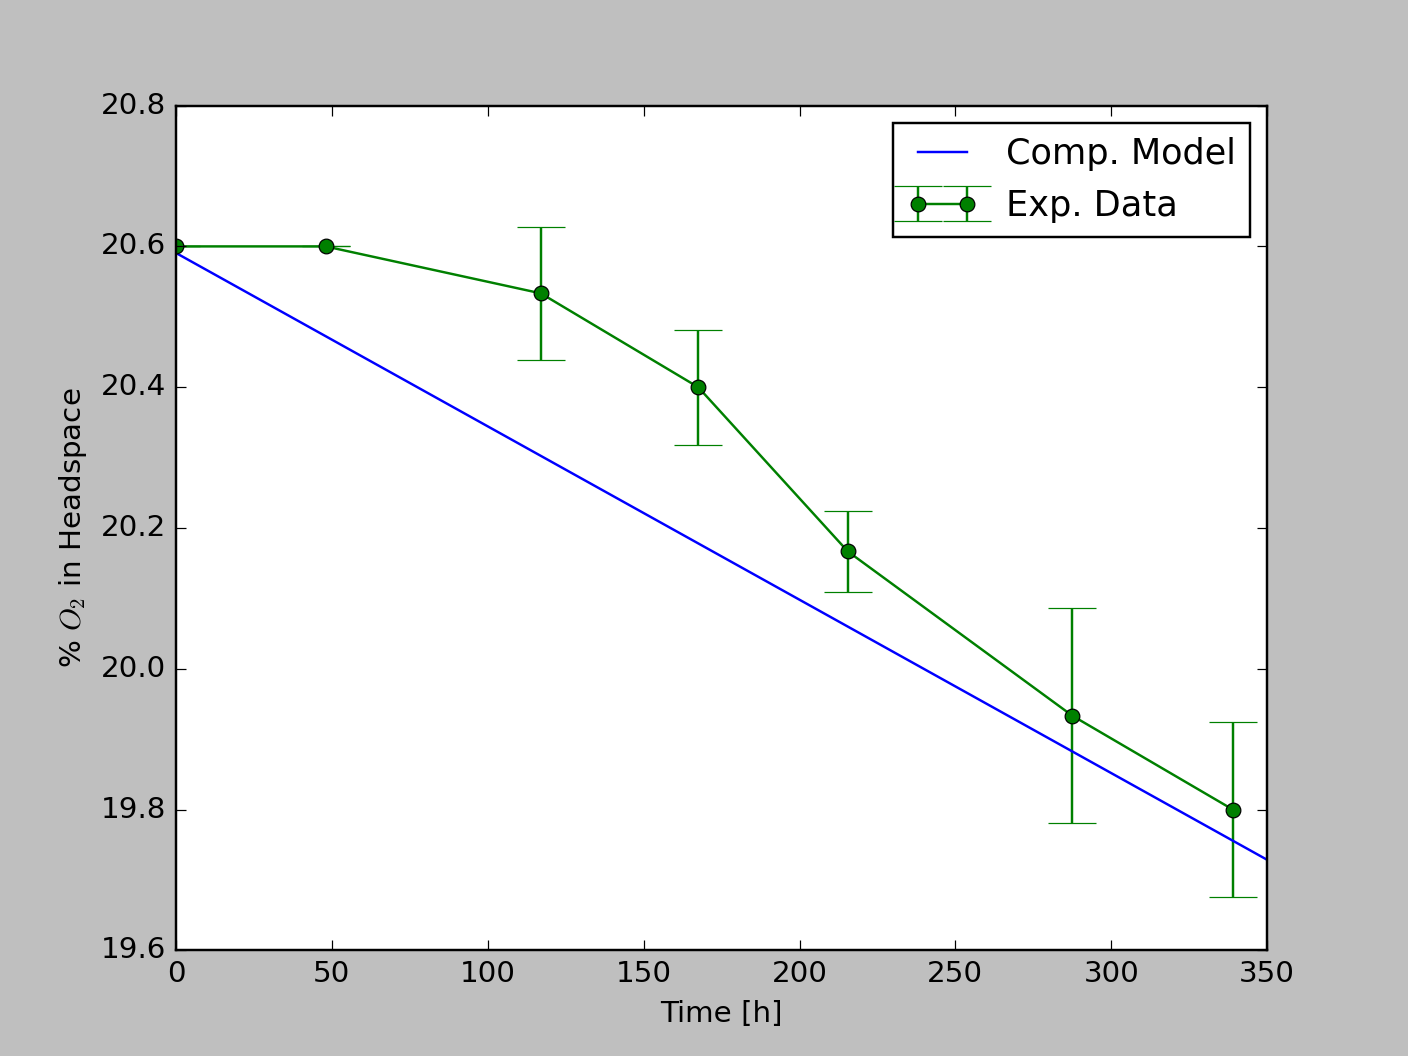

In [151]:
fig=plt.figure()
plt.plot(sol_consumo.t[:]/(3600),sol_consumo.y[-1,:]*(100/P),label='Comp. Model')
plt.errorbar(datos[0][:,0],datos[0][:,1],yerr=datos[0][:,2],fmt='o-',capsize=10,label='Exp. Data');
plt.xlabel('Time [h]')
plt.ylabel('% $O_2$ in Headspace');
plt.legend();


# Solución perfil de concentración con solo Difusión

In [106]:
#Temperatura
T=273+80 #K

#Dimensiones Capsula
r_ext=6.09E-8 #[m]
r_in=3.3940E-08 #[m]

#Vector de radio discretizado
n=500
r=np.linspace(0,r_ext,n)
delta_r=r[1];

#Funcion Escalon 
H=(r_in<r).astype(int);
frontera=np.ravel(np.asarray(H==1).nonzero())[0]

#Difusividad y solubilidad de oxigeno en aceite
def Difusividad(H,T=298):
    Dac=0.4e-9 #m2/s
    D_k=dif_knudsen(T) #m2/s
    return D_k*H+Dac*(1-H)

def Solubilidad(H,T=298):
    R=8.314;
    Sac=6.858e6*np.exp(-1.478e4/(R*T)); #Pa m3/mol
    return H/(R*T)+(1-H)/Sac

#Funcion Difusividad
D=Difusividad(H,T)
S= Solubilidad(H,T)

In [107]:
C=np.zeros([n]);
Co=P*0.21


#Ecuacion Diferencial a solucionar
def ODE(t,C):
    dC=np.empty([n])
    
    dC[0]=(D[0]/delta_r**2)*(2*C[1]-2*C[0])
    dC[1:n-1]=(D[1:n-1]/delta_r**2)*((1+delta_r/r[1:n-1])*C[2:n]-2*C[1:n-1]+(1-delta_r/r[1:n-1])*C[:n-2])
    dC[-1]=D[-1]*(1/(delta_r**2))*((1-delta_r/r[-1])*C[-2]-2*C[-1]+(1+delta_r/r[-1])*Co)
    
    j=frontera;
    dC[j-1]=(D[j]/(3*(D[j-1]+(D[j]))))*(4*dC[j]-dC[j+1])+(D[j-1]/(3*(D[j-1]+(D[j]))))*(4*dC[j-2]-dC[j-3]) 
       
    
    return dC

t=np.linspace(0,0.000001,3600*4+1);
sol= solve_ivp(ODE,[t[0],t[-1]],C,method='BDF');

<IPython.core.display.Javascript object>


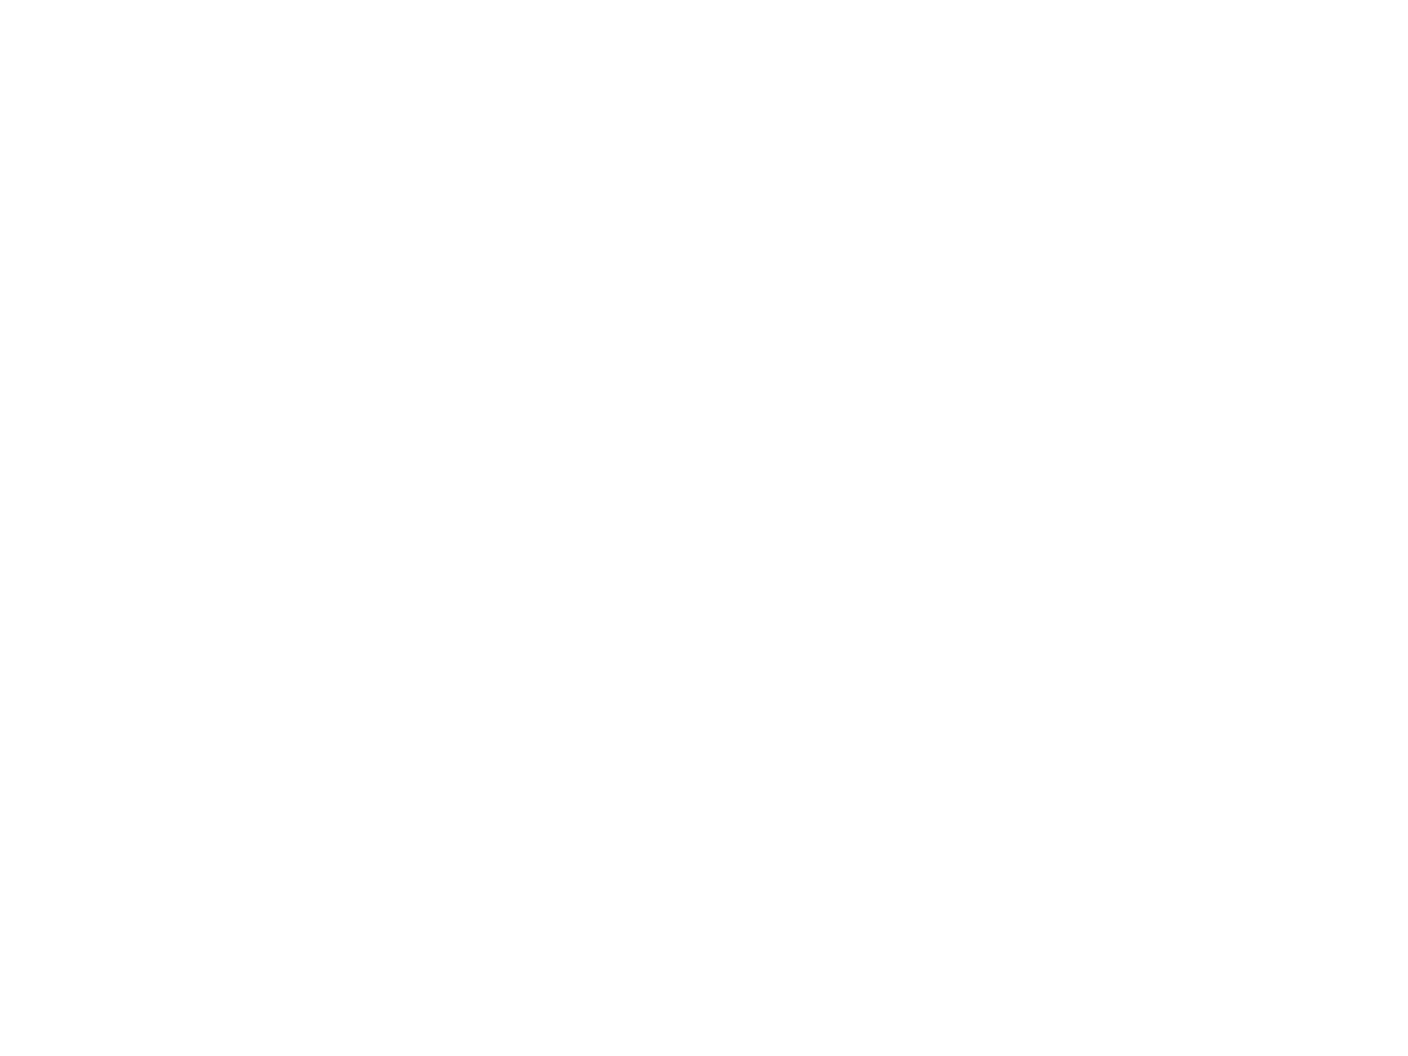

In [108]:
fig=plt.figure()
#p=sol.y[:,:].T/S
#ax = fig.add_subplot(111)
#ax.plot(r[:],sol.y[:,:]);
#plt.plot(r[:],p.T);
#plt.yscale('log')

c=sol.y[:,:].T*S
plt.plot(r[:],c.T);

<IPython.core.display.Javascript object>


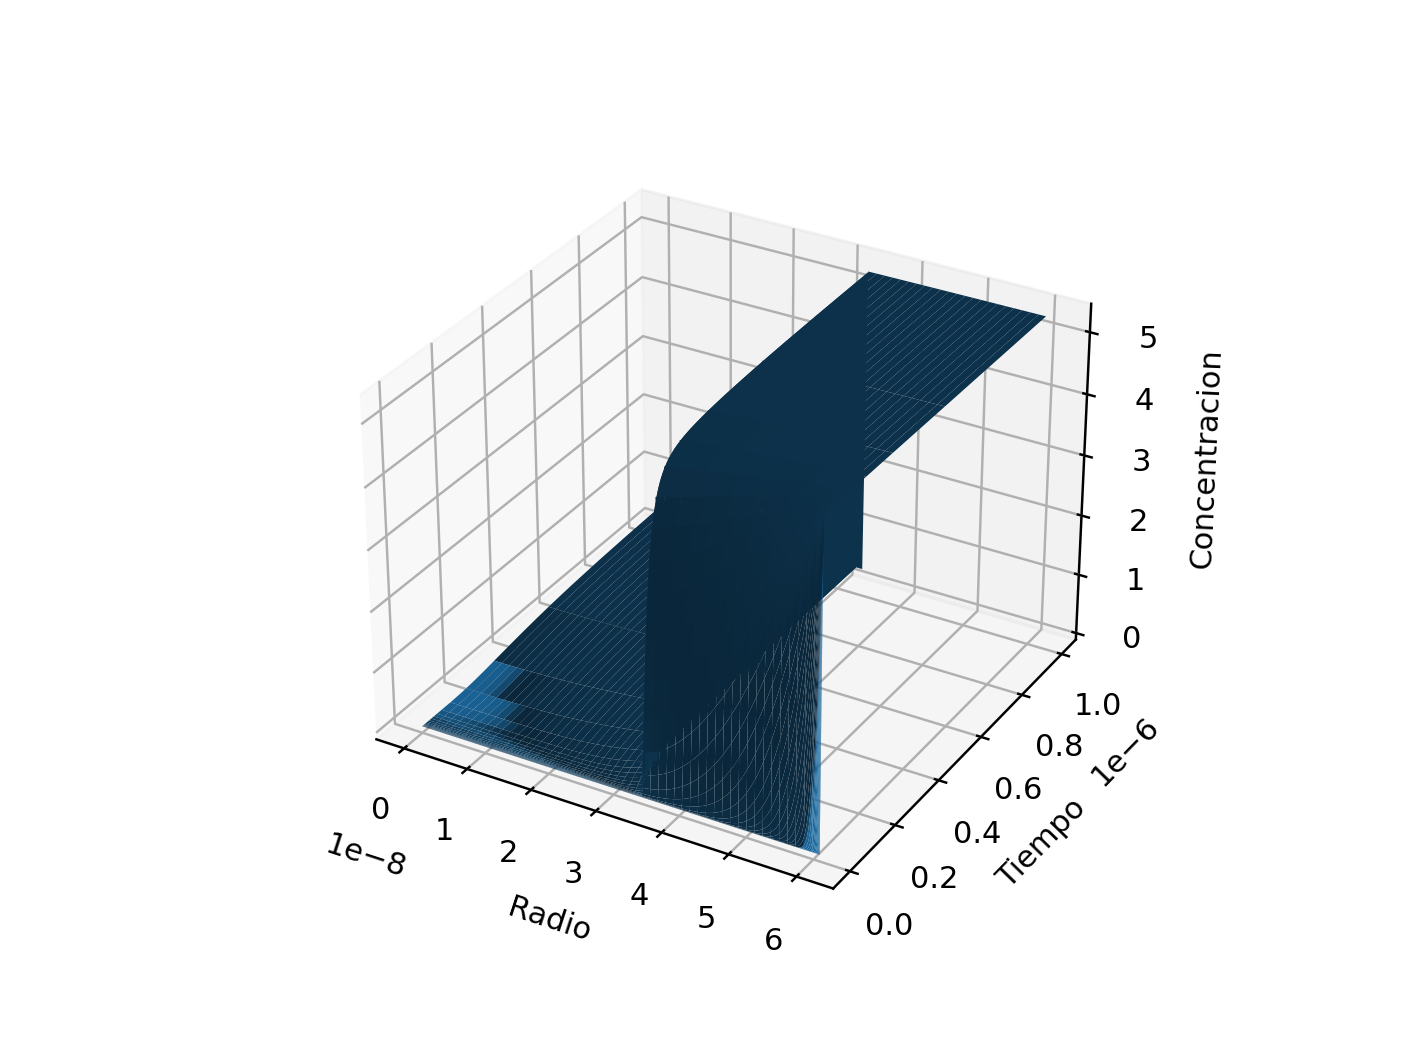

In [109]:
%matplotlib  notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
t_T, R_r = np.meshgrid(sol.t[:],r)
ax.plot_surface(R_r,t_T,c.T);
ax.set_xlabel('Radio')
ax.set_ylabel('Tiempo')
ax.set_zlabel('Concentracion');

# Solucion de perfil de concentración con reacción

<IPython.core.display.Javascript object>


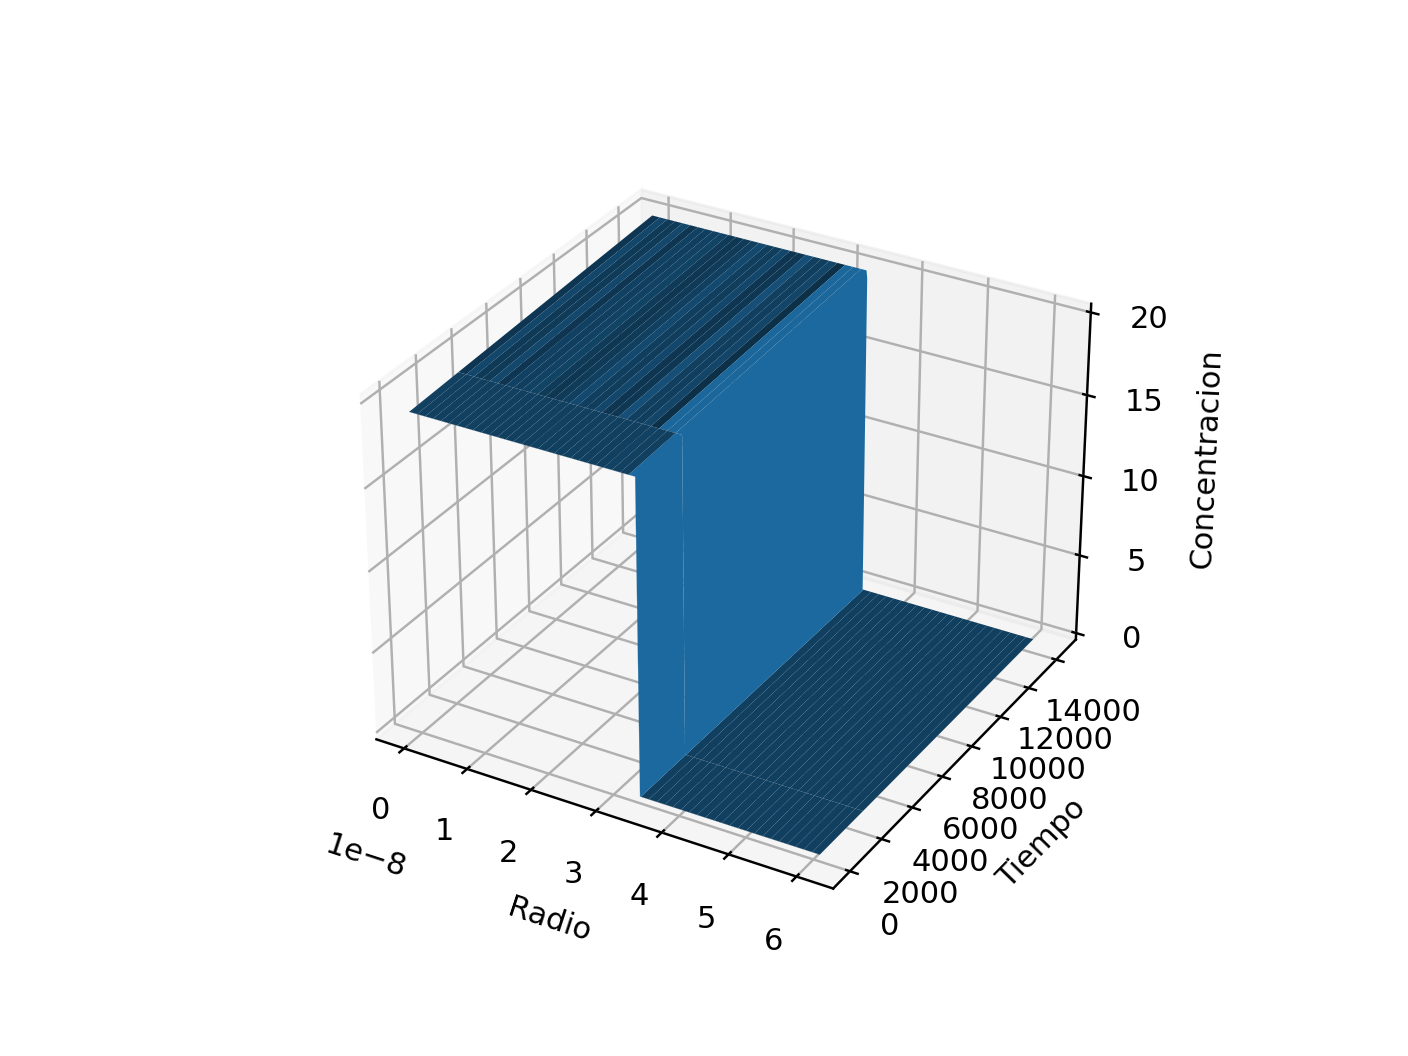

In [135]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
t_T, R_r = np.meshgrid(sol_reac.t[:],r)
ax.plot_surface(R_r,t_T,sol_reac.y[0*n:1*n,:]);
ax.set_xlabel('Radio')
ax.set_ylabel('Tiempo')
ax.set_zlabel('Concentracion');

<IPython.core.display.Javascript object>


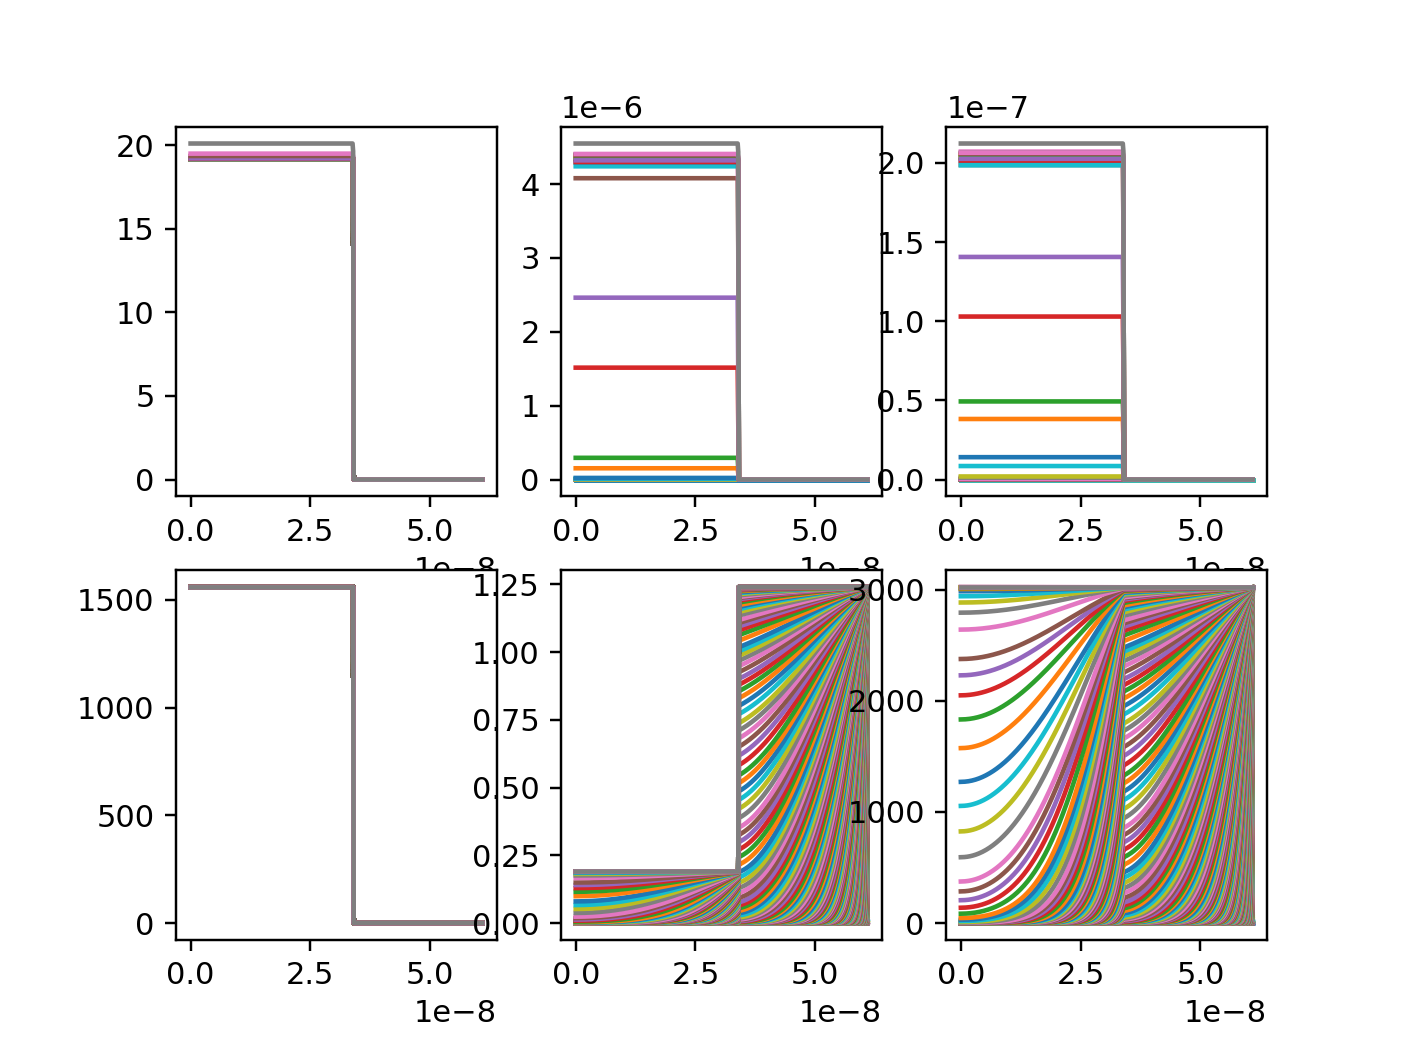

In [134]:
fig=plt.figure()
p=sol_reac.y[4*n:,:].T/S
ax0 = fig.add_subplot(231)
ax1 = fig.add_subplot(232)
ax2 = fig.add_subplot(233)
ax3 = fig.add_subplot(234)
ax4 = fig.add_subplot(235)
ax5 = fig.add_subplot(236)

ax0.plot(r[:],sol_reac.y[0*n:1*n,:]);
ax1.plot(r[:],sol_reac.y[1*n:2*n,:]);
ax2.plot(r[:],sol_reac.y[2*n:3*n,:]);
ax3.plot(r[:],sol_reac.y[3*n:4*n,:]);
ax4.plot(r[:],(sol_reac.y[4*n:5*n,:].T*S).T);
ax5.plot(r[:],sol_reac.y[4*n:5*n,:]);

In [147]:

L=0.025 #[cm]
phi=0.1 #[cm]
n_o=8000
nu=2
S_m=4.38
D_m=4.84e-4
S_r=4.38
D_r=1.73e-4
k_r=0.42;
p_o2=0.21 #atm

L1=(L-(phi*L))/2
L2=L1+phi*L;
#Vector de radio discretizado
n=1000
x=np.linspace(0,L,n)
delta_x=x[1];

#Funcion Escalon
H=np.empty([n])
for i in range(len(x)):
    if (L1<x[i] and L2>x[i]):H[i]=1
    else: H[i]=0;

frontera_1=np.ravel(np.asarray(H==1).nonzero())[0]
frontera_2=np.ravel(np.asarray(H==1).nonzero())[-1]+1;
#Funcion Difusividad
D=D_r*H+D_m*(1-H) 
S=S_r*H+S_m*(1-H)   
#Vector de inicializacion
C=np.ones([n,2])*np.asarray([0,n_o])
C=np.reshape(C.transpose(),2*n);
C[n:]=C[n:]*H
Co=p_o2*S_m;


#Ecuacion Diferencial a solucionar
def ODE(t,C):
    dC=np.empty([2*n])  
    
    dC[1:n-1]=(D[1:n-1]/delta_x**2)*(C[2:n]-2*C[1:n-1]+C[:n-2])-k_r*C[1:n-1]*C[n+1:-1]
    dC[n:]=-nu*k_r*C[:n]*C[n:]
    
    dC[frontera_1]=(D_r/(3*((D_r*S_r/S_m)+D_m)))*(4*dC[frontera_1+1]-dC[frontera_1+2])+(D_m/(3*((D_r*S_r/S_m)+D_m)))*(4*dC[frontera_1-1]-dC[frontera_1-2])
    dC[frontera_2]=(D_m/(3*((D_m*S_m/S_r)+D_r)))*(4*dC[frontera_2+1]-dC[frontera_2+2])+(D_r/(3*((D_m*S_m/S_r)+D_r)))*(4*dC[frontera_2-1]-dC[frontera_2-2])

    
    dC[n+frontera_1]=0.5*(dC[n+frontera_1-1]+dC[n+frontera_1+1])
    dC[n+frontera_2]=0.5*(dC[n+frontera_2-1]+dC[n+frontera_2+1])

    dC[0]=(D[0]/delta_x**2)*(C[1]-2*C[0]+Co)
    dC[n-1]=(D[n-1]/delta_x**2)*(-2*C[n-1]+C[n-2])
    
    return dC

t=np.linspace(0,2000,40+1);
sol= solve_ivp(ODE,[t[0],t[-1]],C,method='BDF');



(0.01, 1000.0)

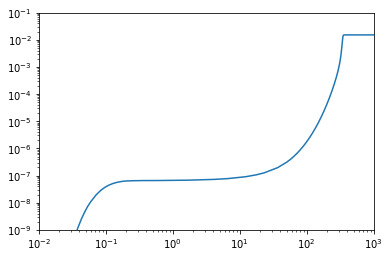

In [148]:
%matplotlib inline
#%matplotlib notebook
fig=plt.figure()
#plt.plot(x[:],sol.y[n:,-1])

J=-D_m*(3*sol.y[n-1,:]-4*sol.y[n-2,:]+sol.y[n-3,:])/(2*delta_x)
plt.plot(sol.t,J)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-9,1e-1])
plt.xlim(left=1e-2,right=1e3)

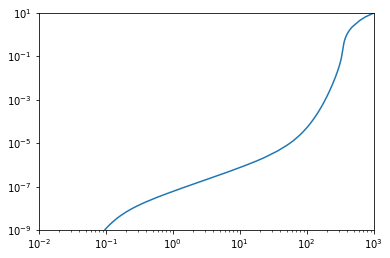

In [149]:
from scipy.integrate import cumtrapz

Q=cumtrapz(J, sol.t, initial=0)

plt.plot(sol.t,Q)
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1e-2,right=1e3)
plt.ylim([1e-9,1e1]);

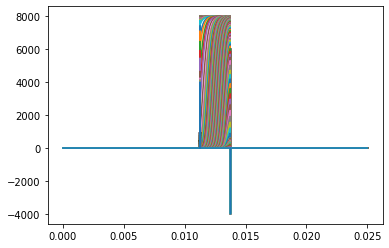

In [161]:
fig=plt.figure()
plt.plot(x[:],sol.y[n:,:-1]);